# Detection de Farudes 

**OBJECTIF :** Construire un modèle de réseau de neurounes performant pour prédire les transactions frauduleuses .

#### Le contexte
Il est important que les sociétés de cartes de crédit soient en mesure de reconnaître les transactions frauduleuses par carte de crédit afin que les clients ne soient pas facturés pour des articles qu'ils n'ont pas achetés.

#### Description
L'ensemble de données contient les transactions effectuées par carte de crédit en septembre 2013 par les titulaires de carte européens.
Cet ensemble de données présente les transactions qui ont eu lieu en deux jours, où nous avons 492 fraudes sur 284 807 transactions. L'ensemble de données est très déséquilibré, la classe positive (fraudes) représente 0,172% de toutes les transactions.

Il ne contient que des variables d'entrée numériques qui sont le résultat d'une transformation PCA. Malheureusement, en raison de problèmes de confidentialité, nous ne pouvons pas fournir les fonctionnalités d'origine et plus d'informations générales sur les données. Les fonctionnalités V1, V2,… V28 sont les principaux composants obtenus avec PCA, les seules fonctionnalités qui n'ont pas été transformées avec PCA sont 'Time' et 'Amount'. La fonction «Temps» contient les secondes écoulées entre chaque transaction et la première transaction de l'ensemble de données. La fonction «Montant» est le montant de la transaction, cette fonction peut être utilisée pour un apprentissage dépendant des coûts, par exemple. La caractéristique «Classe» est la variable de réponse et prend la valeur 1 en cas de fraude et 0 sinon.
 

**Sommaire :**
  * 1. Importation des bibliothèques
  * 2. Importation des données
  * 3. Analyse exploratoire des données
    * 3.1. Analyse de la forme
    * 3.2. Analyse univariée
    * 3.3. Analyse bivariée
  * 4. Prétraitement des données
  * 5. Train validation test split
  * 6. Modelisation
    * 6.1. Méthodes d'évalusation 
    * 6.2. Estimation des hyperparamètres et construction d'un model élaboré
      * 6.2.1. Estimation des hyperparamètres "batch_size", "epochs" et "optimizer"
      * 6.2.2. Estimation du pas d'apprentissage "learning_rate"
      * 6.2.3. Estimation de la fonction d'activation des neurones
      * 6.2.4. Estimation de la régularisation des abandons
      * 6.2.5. Estimation du nombre de neuroune dans la couche cachée
    * 6.3. Entrainement simple du model 
    * 6.4. Entraînement avec pondêration des classes
    * 6.5. Entraînement avec oversampling
      * 6.5.1. Random oversampling
      * 6.5.2. SMOTE
      * 6.5.3. ADASYN
    * 6.6. Entraînement avec undersampling
      * 6.6.1. Random undersampling
      * 6.6.2. Tomek links
    * 6.7. Entraînement avec une approche hybrid de resampling
      * 6.7.1. Random oversampling + Tomek links
      * 6.7.2. SMOTE + Tomek links
    * 7. Conclusion


**Réalisé par :**
  - Yanis AIT HAMMOU
  - Sarah YAKOUBENE


## 1. Importation des bibliothèques

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy.stats import ttest_ind
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline
import os
import tempfile
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## 2. Importation des données

In [ ]:
# les données ne peuvent pas être téléchargées directement sur le lecteur, pour cela nous les importerons directement depuis la machine locale

#path = 'https://drive.google.com/u/0/uc?export=download&confirm=pFCJ&id=1r2ToALFRbqrP7ktphPi8y5gikBjxPP88'

# Importation des données
#data = pd.read_csv(path, sep=";", index_col=0, header=0)

data = pd.read_csv("data/fraud_detection/creditcard.csv")

# Afficher les 5 premieres lignes
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3. Analyse Exploratoire des données

### 3.1. Analyse de la forme

In [ ]:
# Supprimer er récuperer la variable target du dataframe
target = data.Class
data = data.drop(columns=["Class"])

# Afficher les dimension du dataframe
print(f"Dimensions : \n\tlignes : {data.shape[0]}\n\tcolonnes : {data.shape[1]}")

Dimensions : 
	lignes : 284807
	colonnes : 30


L'ensemble de données comporte 30 caractéristiques, dont 28 ont été rendues anonymes et sont étiquetées de V1 à V28. Les trois autres caractéristiques sont la date et le montant de la transaction ainsi que le caractère frauduleux ou non de la transaction.

In [ ]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


L'ensemble des données contient 284 807 transactions. La valeur moyenne de toutes les transactions est de 88,35USD, tandis que la plus grande transaction enregistrée dans cet ensemble de données s'élève à 25 691USD. Cependant au vu de la moyenne et le maximum, la distribution de la valeur monétaire de toutes les transactions est fortement biaisée à droite. La grande majorité des transactions sont relativement petites et seule une infime fraction des transactions se rapproche du maximum.

In [ ]:
# Afficher le nombre de valeurs manquantes, le type des variable et le nombre de valeurs uniques 
df = []
for col in data.columns:
    df.append([col, np.unique(data[col]).shape[0]])
df = pd.DataFrame(df, columns=["col", "# unique values"]).set_index("col")

pd.DataFrame(data.isna().sum()).rename(columns={0: "# missing values"}).join(pd.DataFrame(data.dtypes).rename(columns={0: "# column type"})).join(df)

,# missing values,# column type,# unique values
Time,0,float64,124592
V1,0,float64,275663
V2,0,float64,275663
V3,0,float64,275663
V4,0,float64,275663
V5,0,float64,275663
V6,0,float64,275663
V7,0,float64,275663
V8,0,float64,275663
V9,0,float64,275663


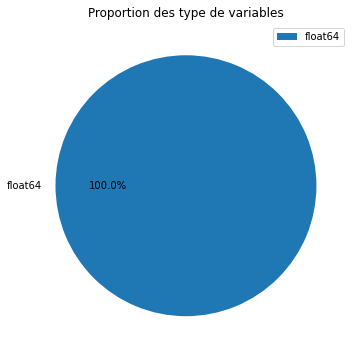

In [ ]:
# Afficher la proportion des types de variables
data.dtypes.value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Proportion des type de variables")
plt.legend()
plt.show()

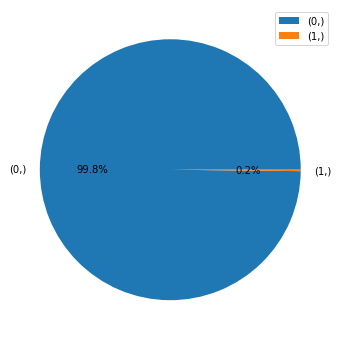

In [ ]:
# Visualisation de la variable target

# Afficher les proportion du nombre d'observation
pd.DataFrame(target).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="")
plt.legend()
plt.show()

np.

Commentaire : Comme on pouvait s'y attendre, la plupart des transactions ne sont pas frauduleuses. La visualisation suivante souligne ce contraste important.

### 3.2. Analyse univariée

C:\Users\SC6136\Library\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


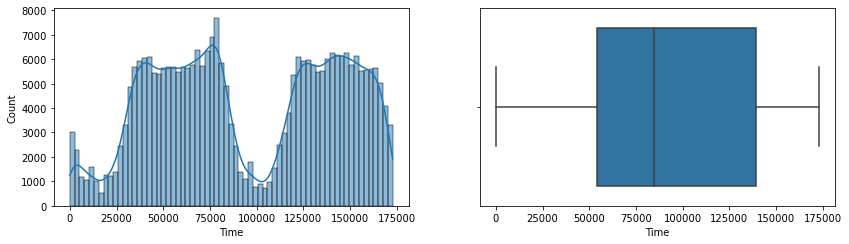

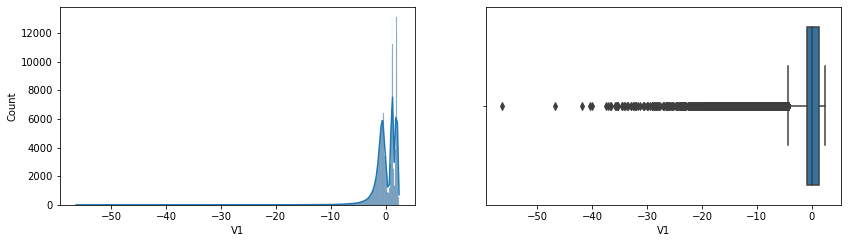

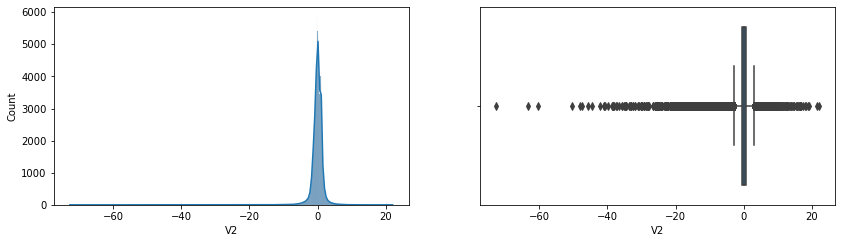

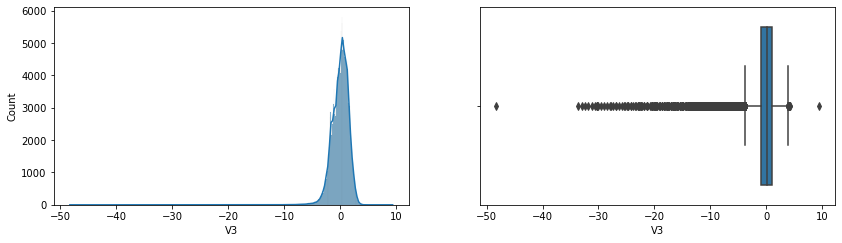

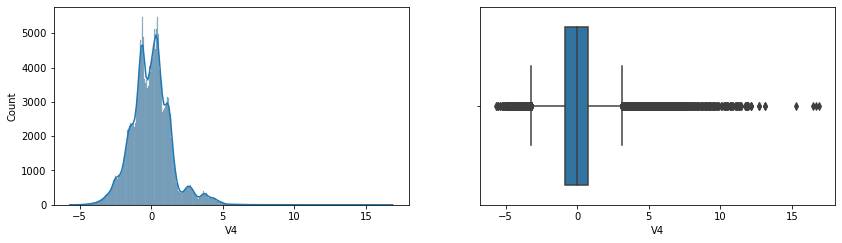

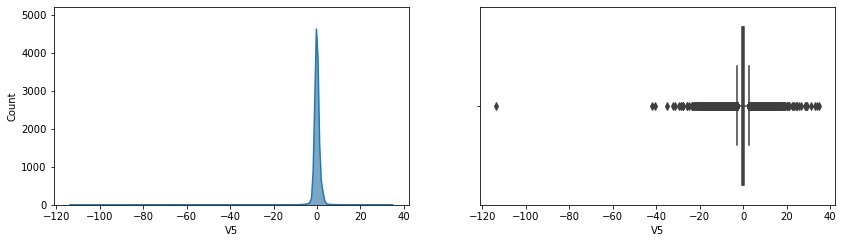

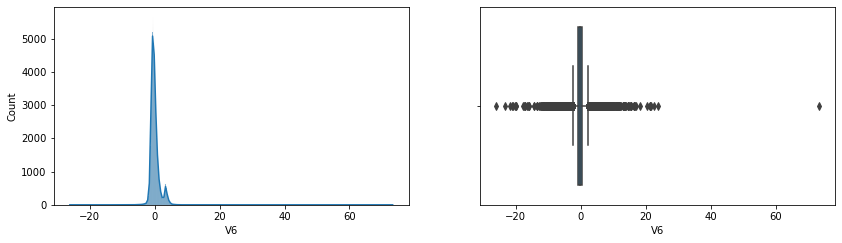

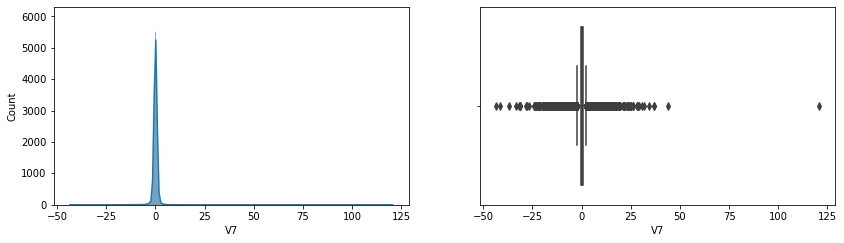

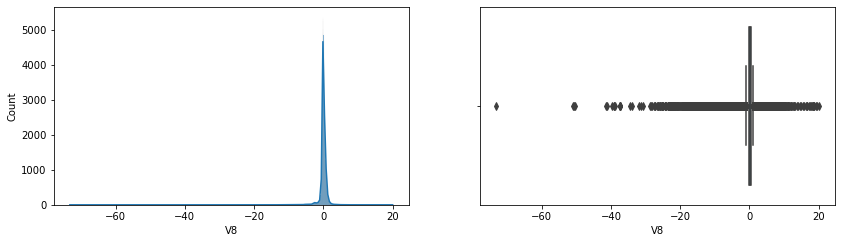

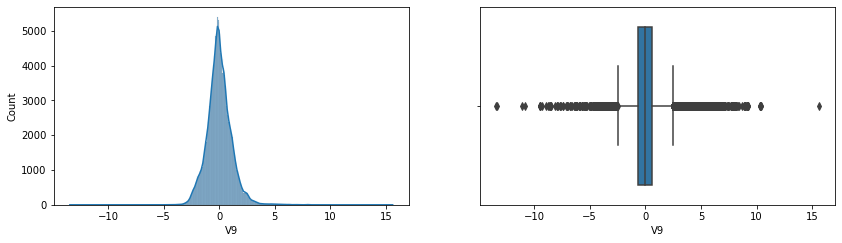

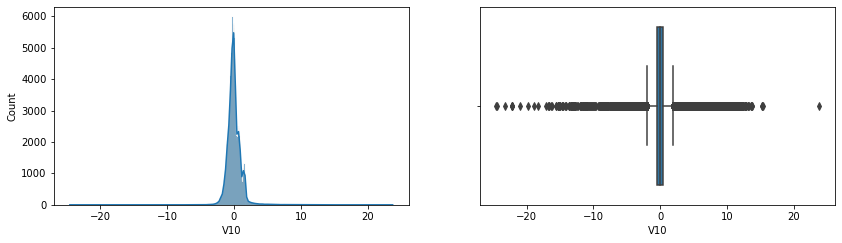

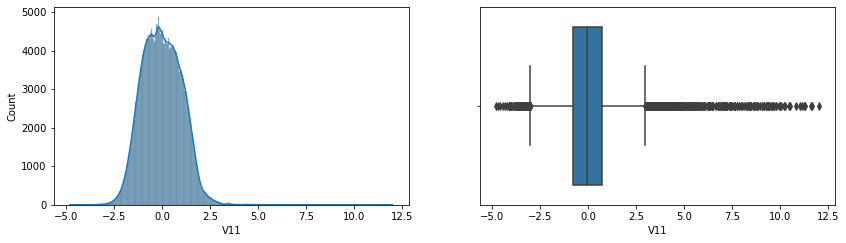

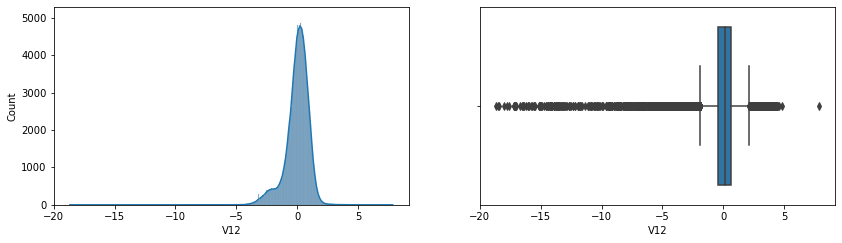

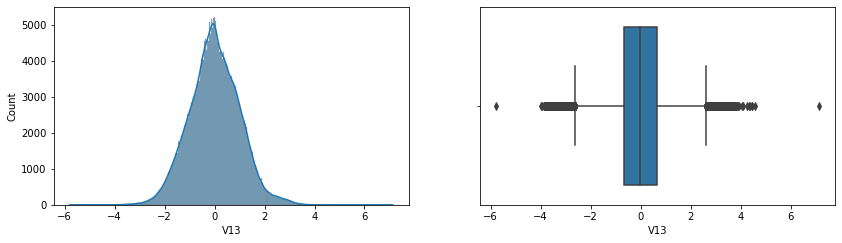

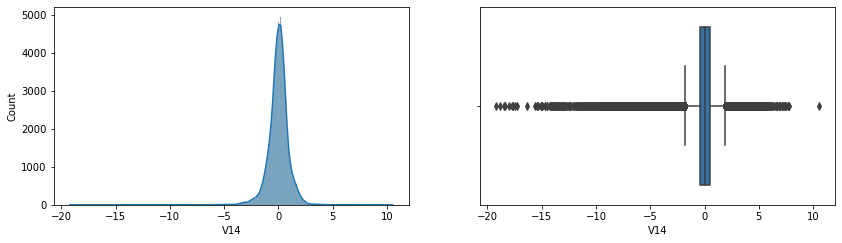

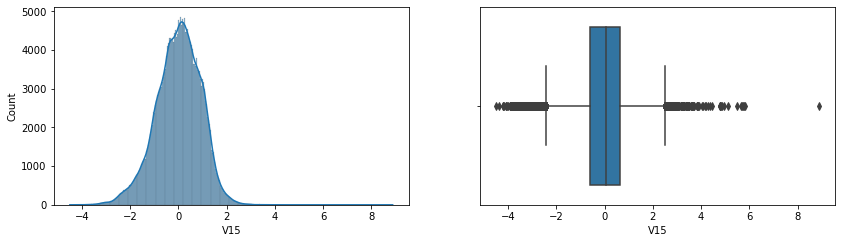

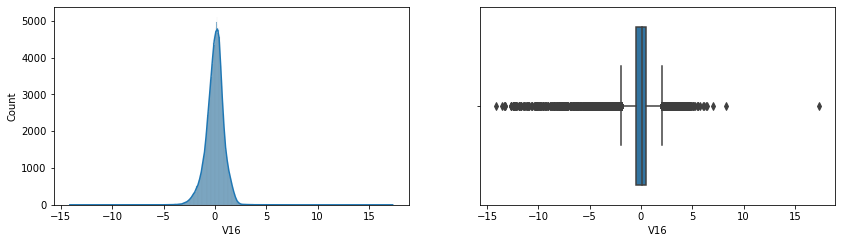

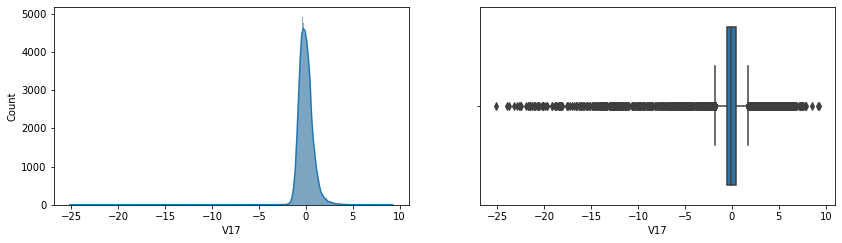

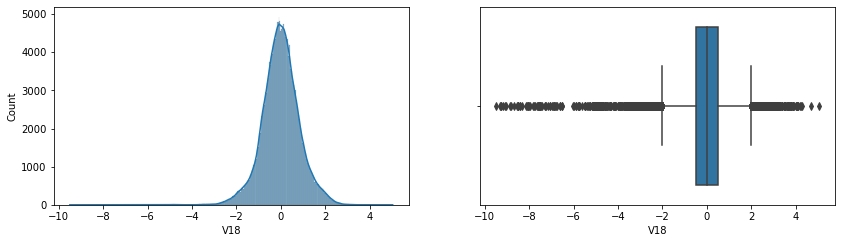

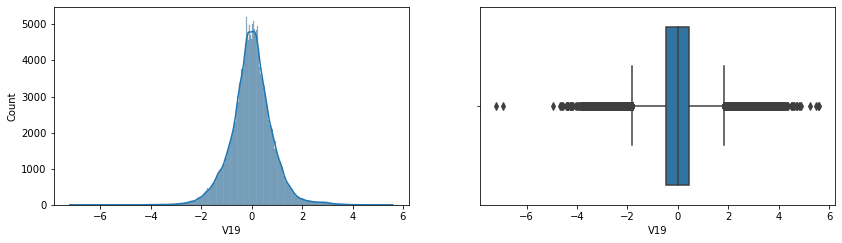

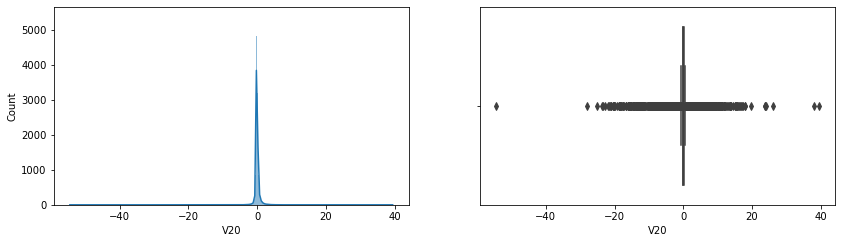

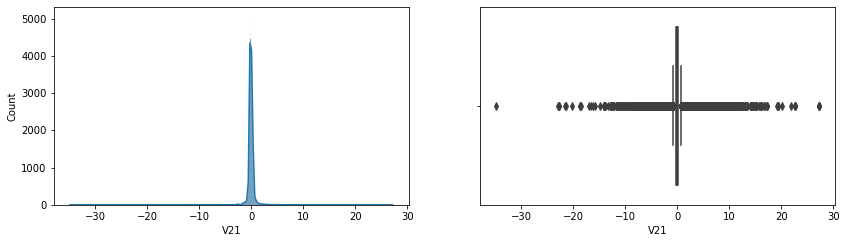

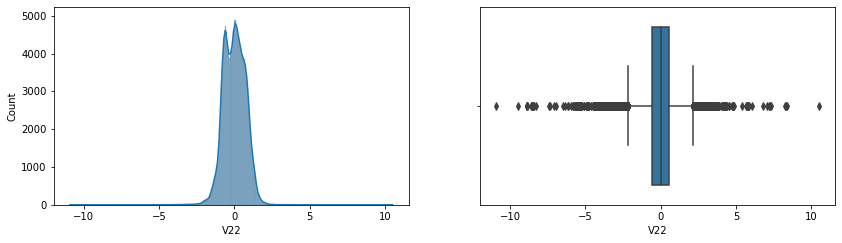

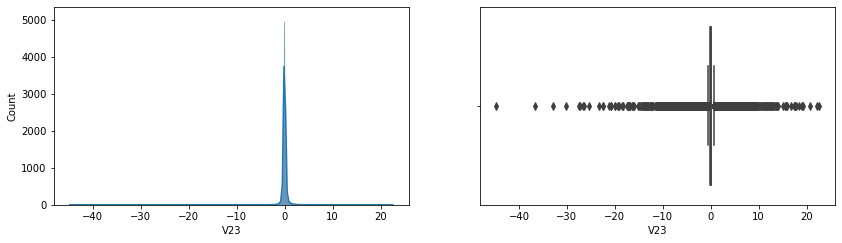

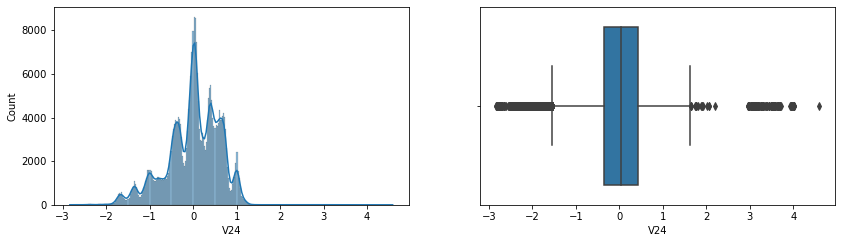

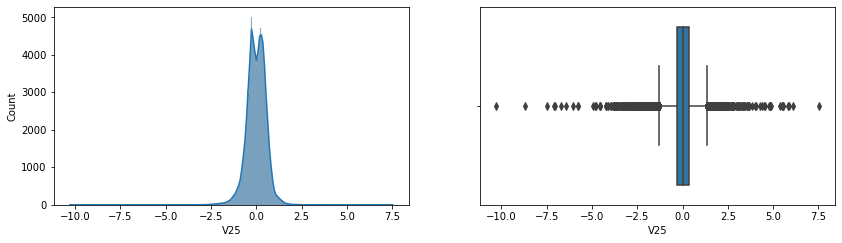

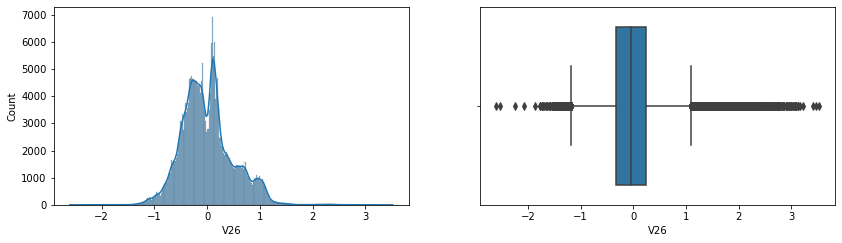

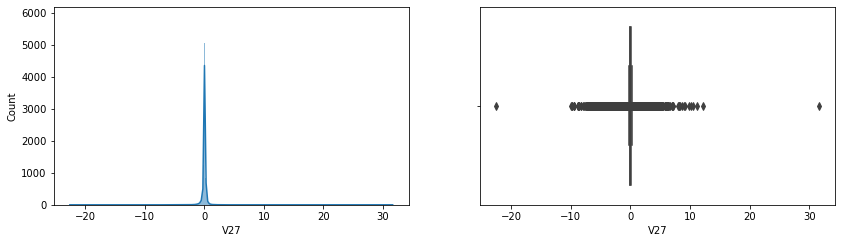

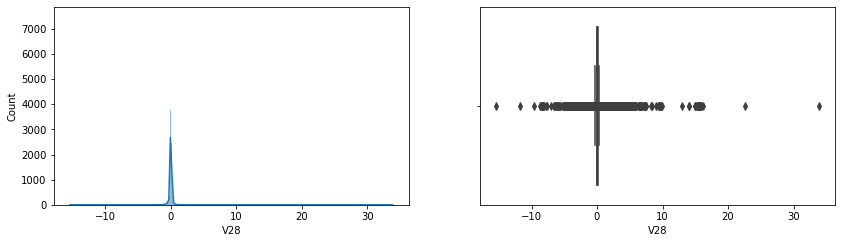

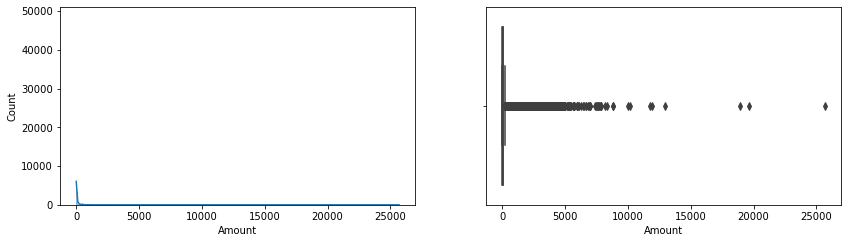

In [ ]:
# Variables Qauntitative
for col in  data.select_dtypes('float').join( data.select_dtypes('int64')):
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 2, 1)
    sns.histplot(data[col], kde=True)
    plt.subplot(2, 2, 2)
    sns.boxplot(data=data, x=col)
plt.show()

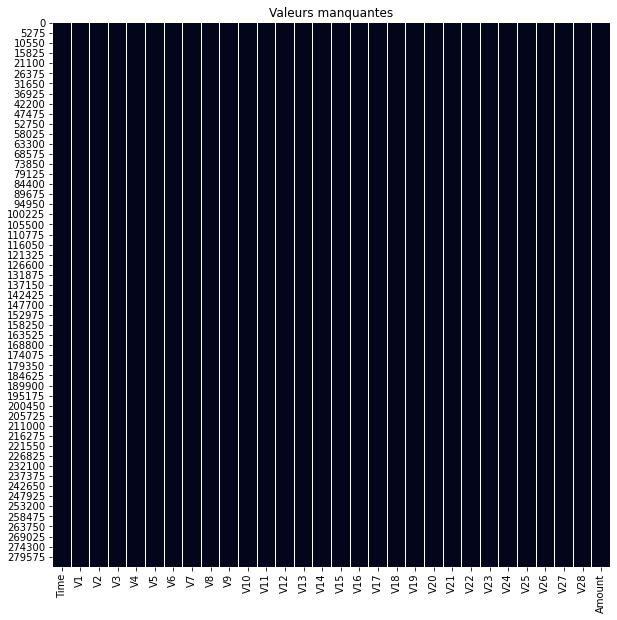

Valeurs manqunates:


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
dtype: int64

In [ ]:
# Visualisation des données manquantes

plt.figure(figsize=(10, 10))
sns.heatmap(data.isnull(), cbar=False)
plt.title("Valeurs manquantes")
plt.show()

print("Valeurs manqunates:")
data.isnull().sum()

### 3.2. Analyse bivariée

In [ ]:
data_fraud = data[target == 1]
data_no_fraud = data[target == 0]

C:\Users\SC6136\Library\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


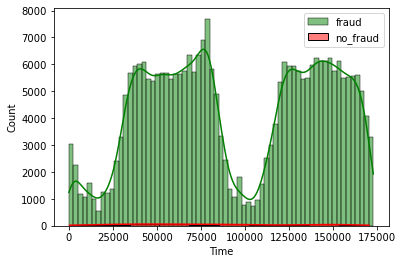

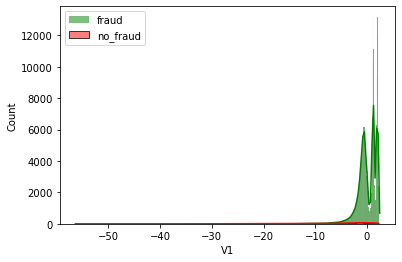

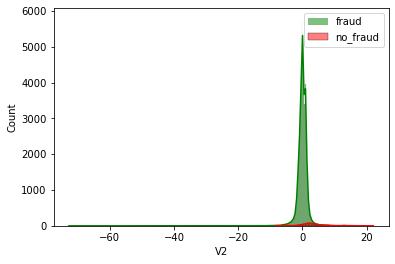

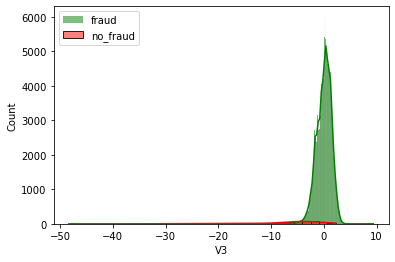

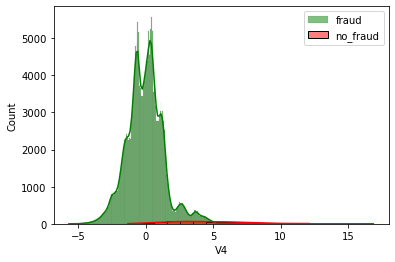

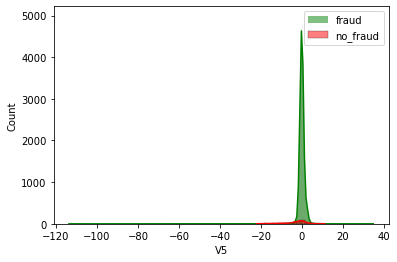

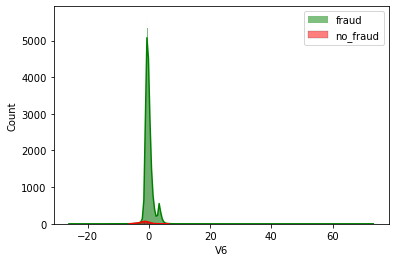

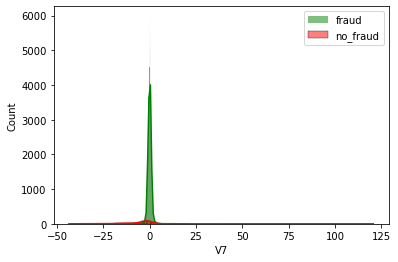

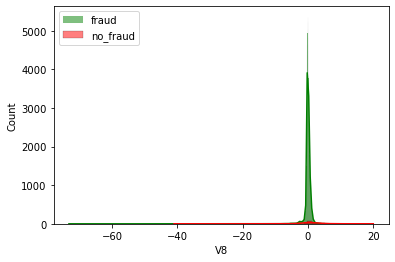

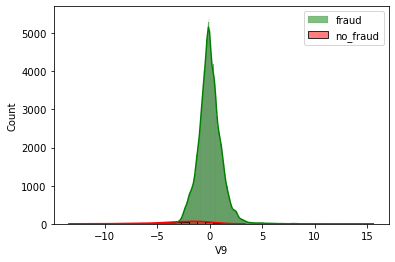

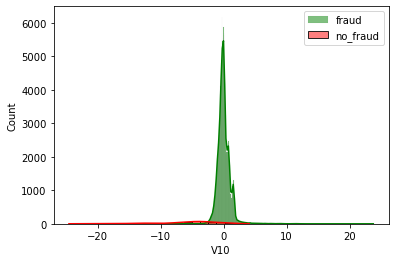

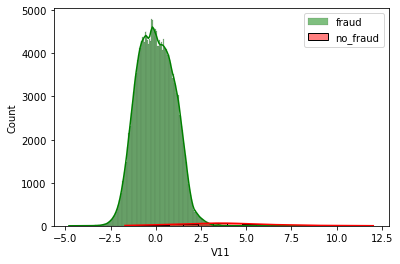

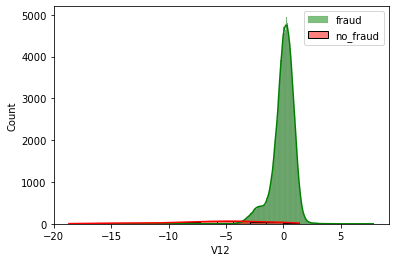

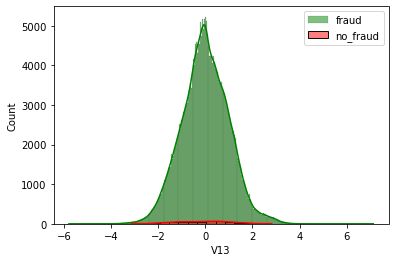

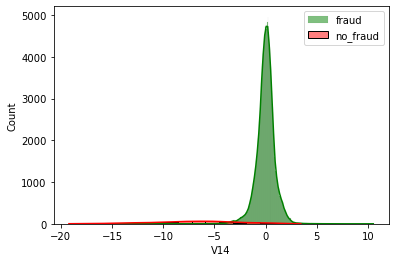

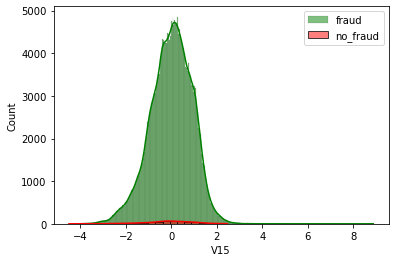

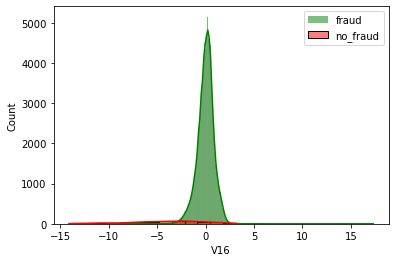

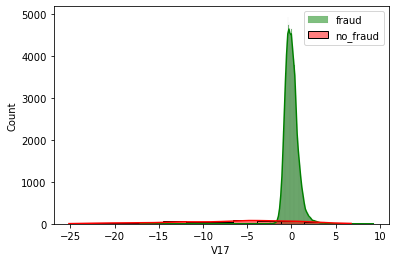

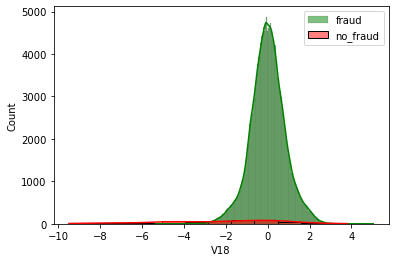

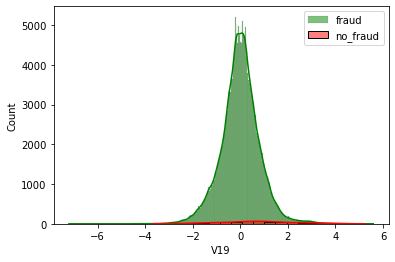

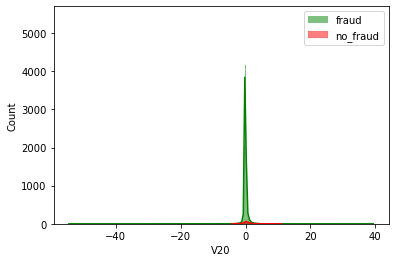

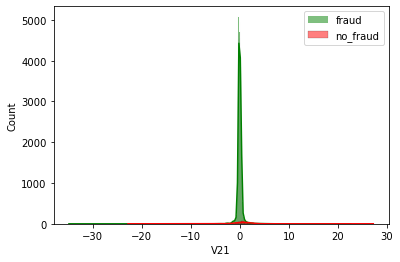

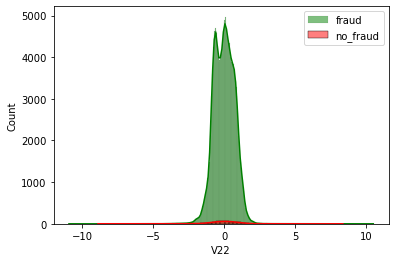

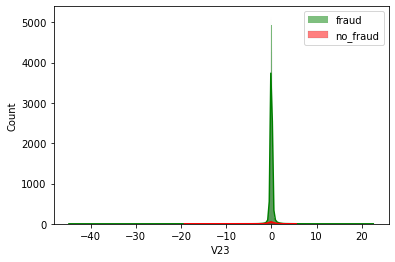

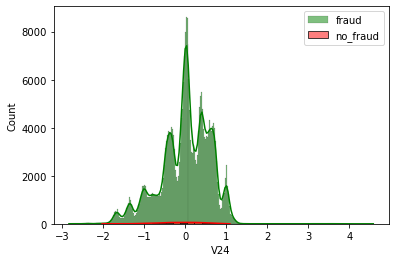

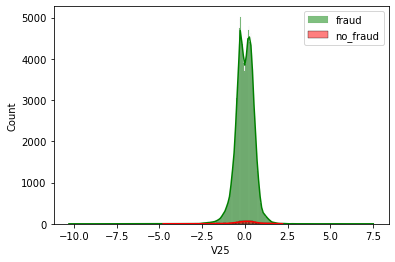

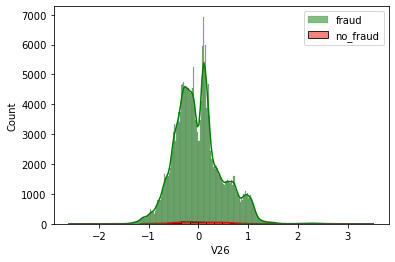

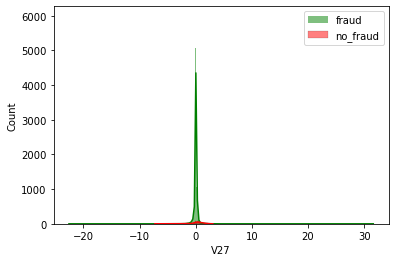

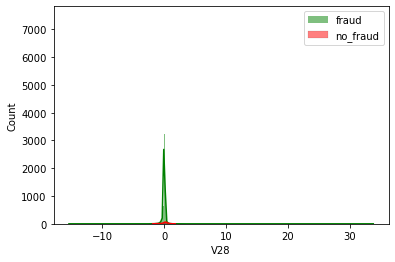

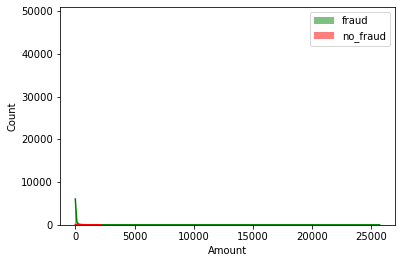

In [ ]:
for col in data.select_dtypes('float'):
    plt.figure()
    sns.histplot(data_yes[col], kde=True, label="fraud", color="green")
    sns.histplot(data_no[col], kde=True, label="no_fraud", color="red")
    plt.legend()

Text(0.5, 1.0, 'CORRELATION w.r.t CLASS')

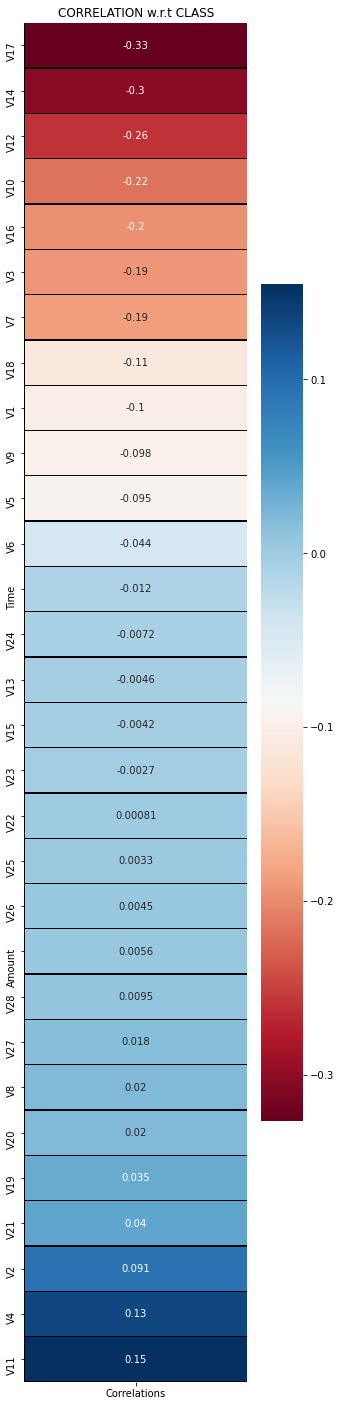

In [ ]:
corr = data.corrwith(target).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,25))
sns.heatmap(corr,annot = True,cmap = 'RdBu',linewidths = 0.4,linecolor = 'black')
plt.title('CORRELATION w.r.t CLASS')

Commentaire : Certains de nos prédicteurs semblent effectivement être corrélés avec la variable de classe. Néanmoins, il semble y avoir relativement peu de corrélations significatives pour un si grand nombre de variables. On reste toujours dans la même logique.

Cela peut probablement être attribué à deux facteurs :

Premièrement le fait que les données soient préparées à l'aide d'une ACP, c'est pourquoi nos prédicteurs sont des composantes principales.
Et deuxièmement l'important déséquilibre des classes pourrait fausser l'importance de certaines corrélations en ce qui concerne notre variable de classe.



## 4. Prétraitement des données

In [ ]:
def preprocessing():
    
    # Créer un copie du dataframe
    df = data.copy()
    
    # Supprimer la variable "Time"
    df = df.drop(columns=["Time"])
    return df

In [ ]:
# Appliquer la fonction de preprocessing sur les données de base
df = preprocessing()

# Afficher le dataframe
df.shape

(284807, 29)

In [ ]:
# Normalisation des données
# Ici 
minmax_scaler = MinMaxScaler().fit(df)
df_normalised = pd.DataFrame(minmax_scaler.transform(df),
                                             columns=df.columns,
                                             index=df.index)
df_normalised

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.756448,0.873531,0.666991,0.160317,0.729603,0.236810,0.235393,0.863749,0.528729,0.598850,...,0.595979,0.564920,0.515249,0.680500,0.313600,0.658558,0.466291,0.433929,0.329840,0.000030
284803,0.945845,0.766677,0.872678,0.219189,0.771561,0.273661,0.265504,0.788548,0.482925,0.488530,...,0.580900,0.564933,0.553153,0.665619,0.245298,0.543855,0.360884,0.417775,0.312038,0.000965
284804,0.990905,0.764080,0.781102,0.227202,0.783425,0.293496,0.263547,0.792985,0.477677,0.498692,...,0.580280,0.565220,0.537005,0.664877,0.468492,0.592824,0.411177,0.416593,0.312585,0.002642
284805,0.954209,0.772856,0.849587,0.282508,0.763172,0.269291,0.261175,0.792671,0.476287,0.500464,...,0.581622,0.565755,0.547353,0.663008,0.398836,0.545958,0.514746,0.418520,0.315245,0.000389


In [ ]:
# Encoder la variable "target"
y = LabelEncoder().fit_transform(target.loc[df_normalised.index])

## 5. Train validation test split

In [ ]:
def train_validation_test_split(X, y, test_size=0.2, validation_size=0.2, random_state=1997):
    
    np.random.seed(random_state)
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    
    train_size = int((1 - test_size - validation_size) * X.shape[0]) 
    validation_size = int(validation_size * X.shape[0]) 
    test_size = int(test_size * X.shape[0])
    
    X_train = X.iloc[index[:train_size], :]
    y_train = y[index[:train_size]]
    
    X_validation = X.iloc[index[train_size : train_size + validation_size], :]
    y_validation = y[index[train_size : train_size + validation_size]]
        
    X_test = X.iloc[index[train_size + validation_size :], :]
    y_test = y[index[train_size + validation_size :] ]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

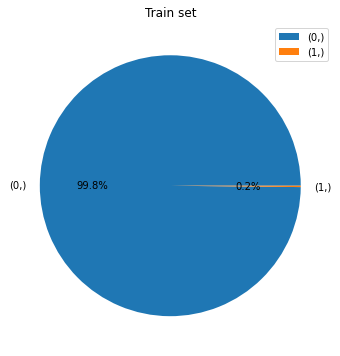

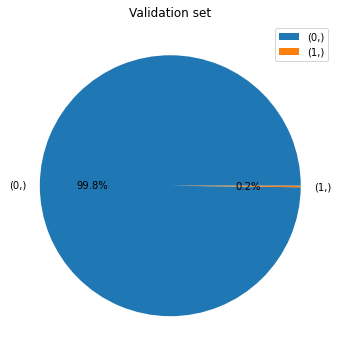

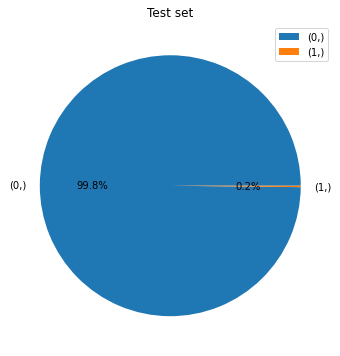

In [ ]:
 X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(df_normalised, y, test_size=0.2, validation_size=0.2)

# Afficher le nombre de donnnées dans chaque classe 
pd.DataFrame(y_train).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()


# Afficher le nombre de donnnées dans chaque classe 
pd.DataFrame(y_validation).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Validation set")
plt.legend()
plt.show()


# Afficher le nombre de donnnées dans chaque classe 
pd.DataFrame(y_test).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Test set")
plt.legend()
plt.show()

# 6. Modelisation

## 6.1 Méthode d'évaludation

In [ ]:
# Definir la méthode d'evaluation du réseau de neuroune
auc_metrics = tf.keras.metrics.AUC(name="auc", curve="PR")


def auc_metric(estimator, X, y):
    
    y_pred = estimator.predict(X)
    
    # calculate sklearn AUC
    lr_precision, lr_recall, _ = precision_recall_curve(labels, pred_prob)
    pr_auc_score = auc(lr_recall, lr_precision)
    
    return pr_auc_score
    
# definir la fonction d'evaluatios robust et informative.
def evaluation(pred_prob, labels):
    
    # calculate sklearn AUC
    lr_precision, lr_recall, _ = precision_recall_curve(labels, pred_prob)
    pr_auc_score = auc(lr_recall, lr_precision)
    print(f"auc= { round(pr_auc_score, 2)}\n\n")
    
    # discretize the results
    pred = pred_prob.copy()
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0

    # Classification report
    print(classification_report(labels, pred))

    # Calculate the confusion matrix
    cm = confusion_matrix(labels, pred)
    sns.heatmap(cm,  annot=True, fmt='d')
    plt.title("Matrice de confusion")
    plt.show()

    
# Afficher le auc et l'erreur durant l'entrainement du model.
def plot_training_history(history):
    acc = history['auc']
    val_acc = history['val_auc']

    loss = history['loss']
    val_loss = history['val_loss']

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Auc')
    plt.plot(val_acc, label='Validation Auc')
    plt.legend(loc='lower right')
    plt.ylabel('auc')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Auc')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## 6.2 Estimation des hyperparamètres

Dans cette partie nous commencerons par estimer les hyperparamètres de notre réseau de neurones, avant d'appliquer les méthodes de "sous-échantillonnage" et de "suréchantillonnage" ect...

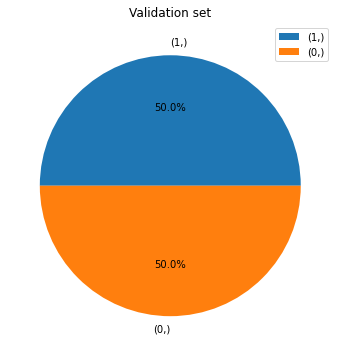

In [ ]:
# Nous allons échantillonner la dataframe pour en extraire un sous-ensemble, afin d'accélérer la phase d'estimation des hyperparamètres
# Ici, nous allons extraire le même numéro de classe, car nous utilisons simplement la précision comme métrique, mais uniquement dans cette partie d'estimation,
# des hyperparamètres, car nous avons des erreurs en utilisant la métrique "AUC" de keras.

index_0 = np.arange(X_train.shape[0])[y_train == 0]
index_1 = np.arange(X_train.shape[0])[y_train == 1]

index_subset = np.concatenate(
    [
        np.random.choice(a=index_0, replace=False, p=np.ones(index_0.shape[0])/index_0.shape[0], size=285),
        index_1
    ], axis=0
)

X_train_subset = X_train.iloc[index_subset, :]
y_train_subset = y_train[index_subset]

# Afficher le nombre de donnnées dans chaque classe 
pd.DataFrame(y_train_subset).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Validation set")
plt.legend()
plt.show()


### 8.2.1. Estimation des hyperparametre "batch_size", "epochs" et "optimizer"

In [ ]:
# Definir la taille d'entrer de la couche cachée 
input_dim = X_train.shape[1]

In [ ]:
def create_model(optimizer='adam', learning_rate=0.001):

    # Creation du model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(12, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compiler le model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model

In [ ]:
# Fixer les nombre aléatoire
seed = 2021
np.random.seed(seed)
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model,  verbose=0)

In [ ]:
# definir la grid des parametres

param_grid = {
    "batch_size" : [1, 2, 5, 10, 20, 40, 60, 80, 100],
    "epochs" : [10, 50, 100],
    "optimizer" : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] 
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)

grid_result = grid.fit(X_train_subset, y_train_subset)

# evaluation
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 189 candidates, totalling 945 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 945 out of 945 | elapsed: 13.9min finished


Best: 0.912281 using {'batch_size': 5, 'epochs': 50, 'optimizer': 'RMSprop'}


### 6.2.2. Estimation de l'hyperparametre "learning_rate"

In [ ]:
# Definir les hyperparametres precedement estimés
epochs = 50
batch_size = 5

In [ ]:
def create_model(learning_rate=0.001):

    # Creation du model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(12, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # definir l'optimizer
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, name="RMSprop")

    # Compiler le model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model

In [ ]:
# Fixer les nombre aléatoire
seed = 2021
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
# definir la grid des parametres

param_grid = {
    "learning_rate" : [0.01, 0.001, 0.0001, 0.00001]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)

grid_result = grid.fit(X_train_subset, y_train_subset)

# evaluation
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   12.1s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.4s finished


Best: 0.896491 using {'learning_rate': 0.001}


### 6.2.3. Estimation de la fonction d'activation des neurones

In [ ]:
def create_model(activation="relu"):
    
 # Creation du model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(12, input_dim=input_dim, activation=activation))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # definir l'optimizer
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, name="RMSprop")

    # Compiler le model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model

In [ ]:
# Fixer les nombre aléatoire
seed = 2021
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
# definir la grid des parametres

param_grid = {
    "activation" : ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)

grid_result = grid.fit(X_train_subset, y_train_subset)

# evaluation
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   31.6s finished


Best: 0.907018 using {'activation': 'tanh'}


### 6.2.4. Estimation de la régularisation des abandons

In [ ]:
def create_model(dropout_rate=0.0):

 # Creation du model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(12, input_dim=input_dim, activation="tanh"))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # definir l'optimizer
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, name="RMSprop")

    # Compiler le model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model

In [ ]:
# Fixer les nombre aléatoire
seed = 2021
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
# definir la grid des parametres

param_grid = {
    "dropout_rate" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)

grid_result = grid.fit(X_train_subset, y_train_subset)

# evaluation
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.9s finished


Best: 0.924561 using {'dropout_rate': 0.4}


### 6.2.5. Estimation du nombre de neuroune dans la couche cachée

In [ ]:
def create_model(neurons=1):

 # Creation du model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neurons, input_dim=input_dim, activation="tanh"))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # definir l'optimizer
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, name="RMSprop")

    # Compiler le model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model

In [ ]:
# Fixer les nombre aléatoire
seed = 2021
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
# definir la grid des parametres

param_grid = {
    "neurons" : [1, 5, 10, 15, 20, 25, 30]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)

grid_result = grid.fit(X_train_subset, y_train_subset)

# evaluation
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   28.4s finished


Best: 0.914035 using {'neurons': 30}


In [ ]:
# Definir la taille d'entrer de la couche cachée 
input_dim = X_train.shape[1]

# Définir la fonction, pour construire le modèle de base
def create_baseline_model():

    # Creation du model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(12, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compiler le model
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=[auc_metrics])

    return model


# Définir la fonction, pour construire le modèle adapté
def create_elaborate_model():

 # Creation du model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(30, input_dim=input_dim, activation="tanh"))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # definir l'optimizer
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, name="RMSprop")

    # Compiler le model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[auc_metrics])

    return model

## 6.3. Entraînement simple

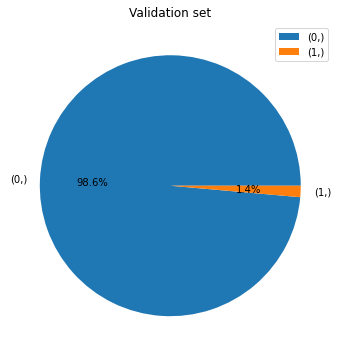

In [ ]:
# Nous allons échantillonner la dataframe pour en extraire un sous-ensemble, afin d'accélérer la phase d'estimation des hyperparamètres
# Ici, nous allons extraire le même numéro de classe, car nous utilisons simplement la précision comme métrique, mais uniquement dans cette partie d'estimation,
# des hyperparamètres, car nous avons des erreurs en utilisant la métrique "AUC" de keras.

index_0 = np.arange(X_train.shape[0])[y_train == 0]
index_1 = np.arange(X_train.shape[0])[y_train == 1]

index_subset = np.concatenate(
    [
        np.random.choice(a=index_0, replace=False, p=np.ones(index_0.shape[0])/index_0.shape[0], size=20000),
        index_1
    ], axis=0
)

X_train = X_train.iloc[index_subset, :]
y_train = y_train[index_subset]

# Afficher le nombre de donnnées dans chaque classe 
pd.DataFrame(y_train).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Validation set")
plt.legend()
plt.show()


In [ ]:
# Definir les hyperparametres precedement estimés
epochs = 50
batch_size = 5

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

56962/56962 [==============================] - 1s 21us/sample - loss: 0.0051 - auc: 0.7567
AUC: 75.67


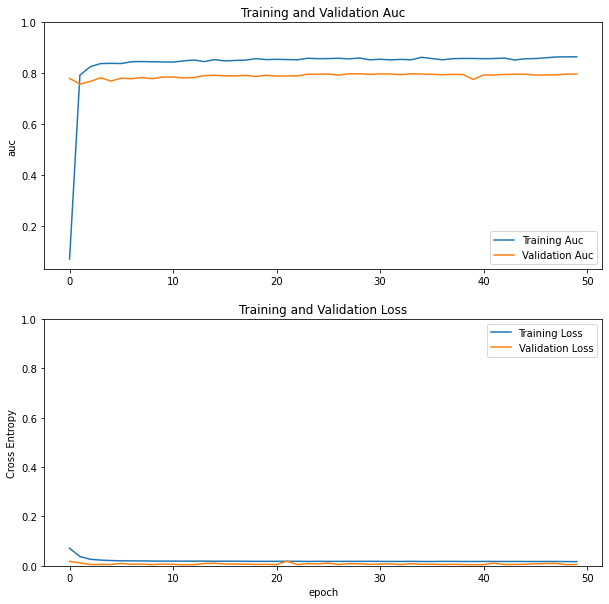

auc= 0.77


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.83      0.82      0.82       100

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



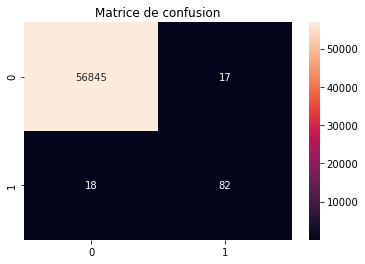


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

56962/56962 [==============================] - 1s 21us/sample - loss: 0.0128 - auc: 0.7076
AUC: 70.76


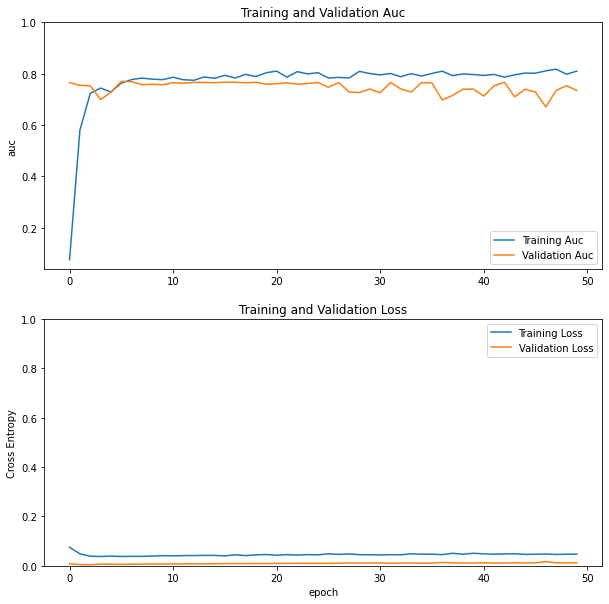

auc= 0.79


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.80      0.83      0.81       100

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



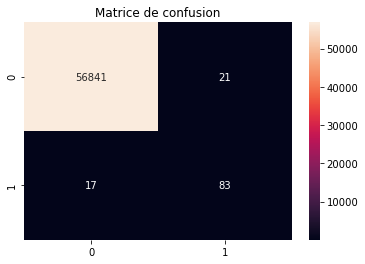

In [ ]:
# Construire le modèle de base et le modèle élaboré
#baseline_model = create_baseline_model()
#elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
#history_b= baseline_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=1)
print("\nelaborate model fit")
#history_e= elaborate_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=1)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

## 6.4. Entraînement avec pondération des classes


In [ ]:
# Définir la fonction pour calculer le poid de chaque classe 
def count_class_weight(data_labels):
    max_val = max((data_labels == 0).sum(), (data_labels == 1).sum())  
    class_weight = {
        0: round(max_val/(data_labels == 0).sum(), 2),
        1: round(max_val/(data_labels == 1).sum(), 2)
    }
    return class_weight

In [ ]:
# Calculer le de chaque classe 
class_weight = count_class_weight(y_train)
class_weight

{0: 1.0, 1: 70.18}

baseline model fit
  ...
    to  
  ['...']
  ...
    to  
  ['...']

elaborate model fit
  ...
    to  
  ['...']
  ...
    to  
  ['...']

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

56962/56962 [==============================] - 2s 28us/sample - loss: 0.2756 - auc: 0.6593
AUC: 65.93


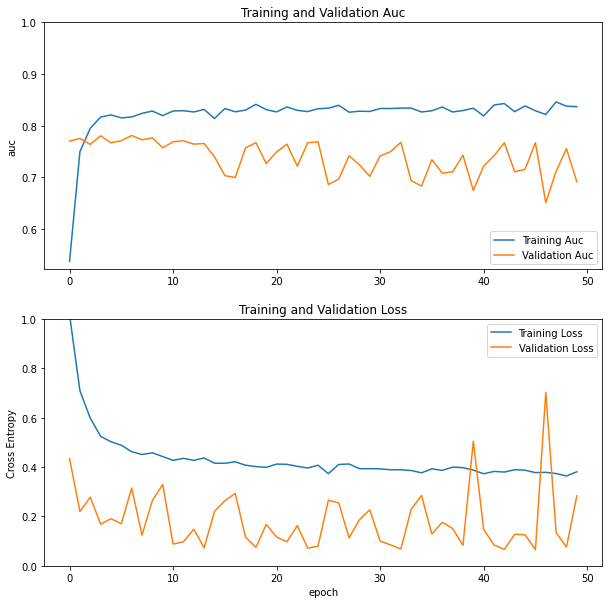

auc= 0.75


              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56862
           1       0.02      0.93      0.04       100

    accuracy                           0.92     56962
   macro avg       0.51      0.92      0.50     56962
weighted avg       1.00      0.92      0.96     56962



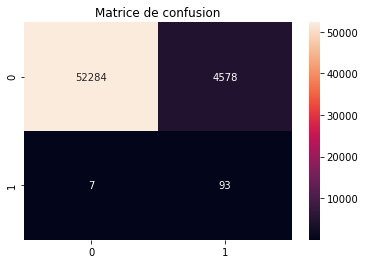


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

56962/56962 [==============================] - 1s 24us/sample - loss: 0.0129 - auc: 0.6956
AUC: 69.56


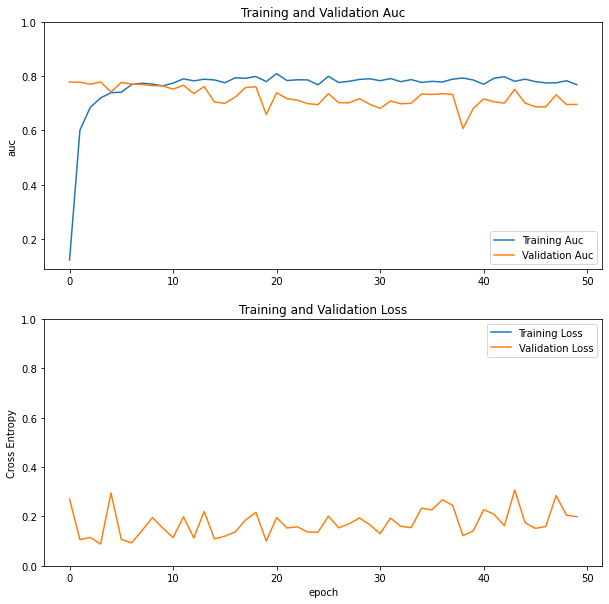

auc= 0.78


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.74      0.83      0.78       100

    accuracy                           1.00     56962
   macro avg       0.87      0.91      0.89     56962
weighted avg       1.00      1.00      1.00     56962



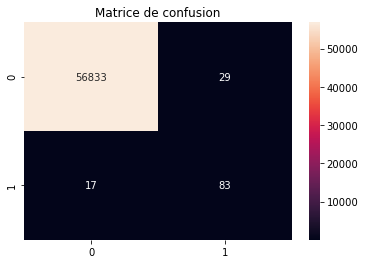

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0, class_weight=class_weight)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0, class_weight=class_weight)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

## 6.5. Entraînement avec oversampling

### 8.5.1. Random oversampling

le suréchantillonnage est une façon de résoudre ce problème est de suréchantillonner les exemples dans la classe minoritaire. Cela peut être réalisé en dupliquant simplement des exemples de la classe minoritaire dans l'ensemble de données d'apprentissage avant d'ajuster un modèle. Cela peut équilibrer la distribution des classes mais ne fournit aucune information supplémentaire au modèle.

In [ ]:
# Definir la fonction
def sampling(X, y, sampling_strategy=None, shuffle=True, random_state=1997):
    
    if random_state is not None:
        np.random.seed(random_state)
        
    index_classe_0 = np.arange(y.shape[0])[y == 0]
    index_classe_1 = np.arange(y.shape[0])[y == 1]
    
    if sampling_strategy is None:
        if index_classe_0.shape > index_classe_1.shape[0]:
            index_classe_1 = np.random.choice(index_classe_1, p=np.ones(index_classe_1.shape[0])/index_classe_1.shape[0], replace=True, size=index_classe_0.shape[0])
        else:
            index_classe_0 = np.random.choice(index_classe_0, p=np.ones(index_classe_0.shape[0])/index_classe_0.shape[0], replace=True, size=index_classe_1.shape[0])
    else:
        index_classe_1 = np.random.choice(index_classe_1, p=np.ones(index_classe_1.shape[0])/index_classe_1.shape[0], replace=True, size=sampling_strategy[1])
        index_classe_0 = np.random.choice(index_classe_0, p=np.ones(index_classe_0.shape[0])/index_classe_0.shape[0], replace=True, size=sampling_strategy[0])

    X, y = pd.concat([X.iloc[index_classe_0], X.iloc[index_classe_1]], axis=0), np.array([0]*sampling_strategy[0] + [1]*sampling_strategy[1])
    
    if shuffle:
        index = np.arange(X.shape[0])
        np.random.shuffle(index)
        return X.iloc[index], y[index]
    
    return X, y

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([20000,   285], dtype=int64))

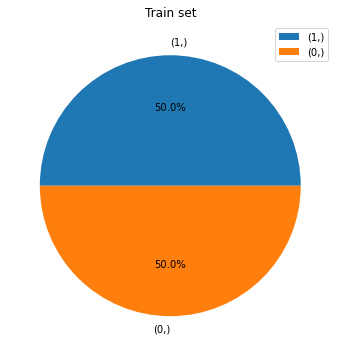

(array([0, 1]), array([20000, 20000], dtype=int64))

In [ ]:
over_strategy = {0:20000, 1:20000}
X_train_over, y_train_over =  sampling(X_train, y_train, sampling_strategy=over_strategy, random_state=1997)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_over).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_over, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

56962/56962 [==============================] - 1s 22us/sample - loss: 0.1316 - auc: 0.6407
AUC: 64.07


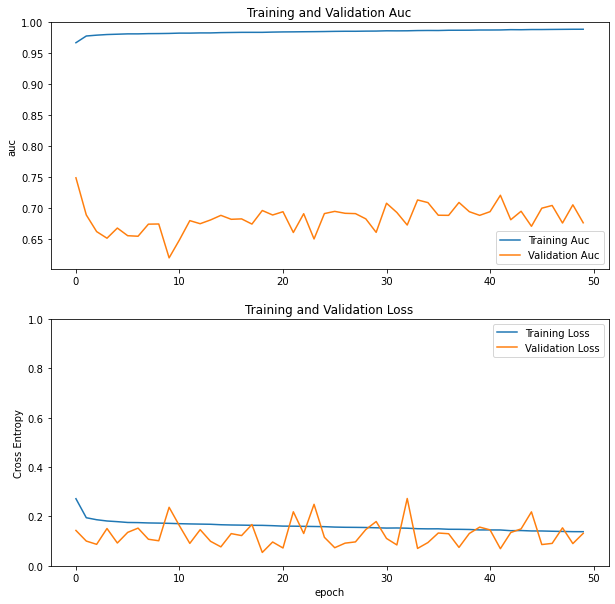

auc= 0.78


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56862
           1       0.04      0.92      0.07       100

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.96      0.98     56962



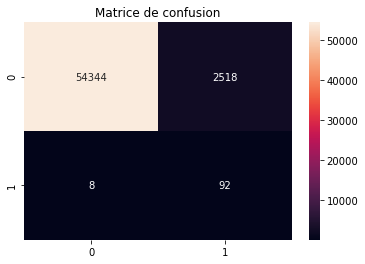


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

56962/56962 [==============================] - 1s 21us/sample - loss: 0.1246 - auc: 0.5471
AUC: 54.71


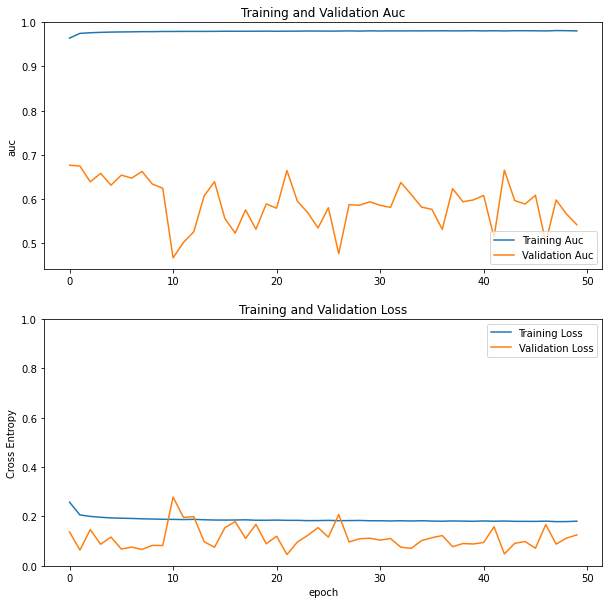

auc= 0.75


              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56862
           1       0.05      0.90      0.09       100

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.54     56962
weighted avg       1.00      0.97      0.98     56962



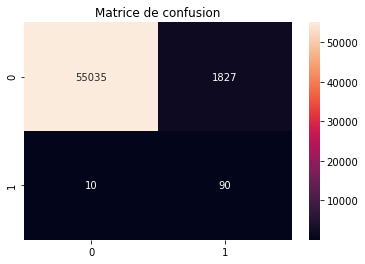

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_over, y_train_over, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_over, y_train_over, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

### 6.5.2. SMOTE
SMOTE fonctionne en sélectionnant des exemples qui sont proches dans l'espace des variables, en traçant une ligne entre les exemples dans l'espace des fonctionnalités et en dessinant un nouvel échantillon en un point le long de cette ligne.

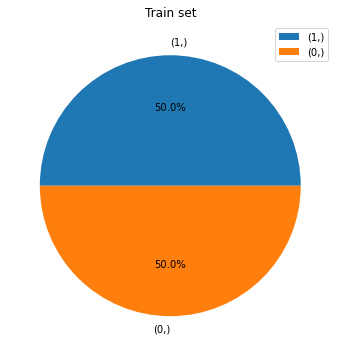

(array([0, 1], dtype=int64), array([20000, 20000], dtype=int64))

In [ ]:
smote_strategy = {0:20000, 1:20000 }
X_train_smote, y_train_smote =  SMOTE(sampling_strategy=smote_strategy, random_state=1997).fit_resample(X_train, y_train)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_smote).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_smote, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

56962/56962 [==============================] - 1s 22us/sample - loss: 0.1246 - auc: 0.7329
AUC: 73.29


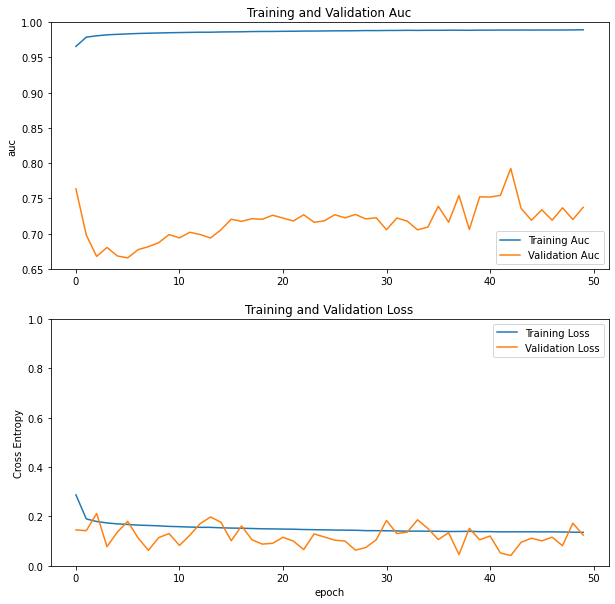

auc= 0.77


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56862
           1       0.04      0.89      0.07       100

    accuracy                           0.96     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.96      0.98     56962



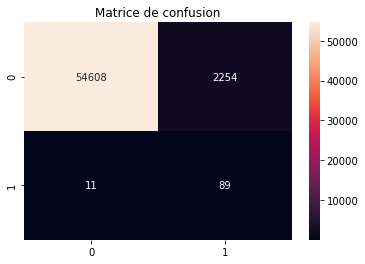


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

56962/56962 [==============================] - 1s 23us/sample - loss: 0.1144 - auc: 0.4837
AUC: 48.37


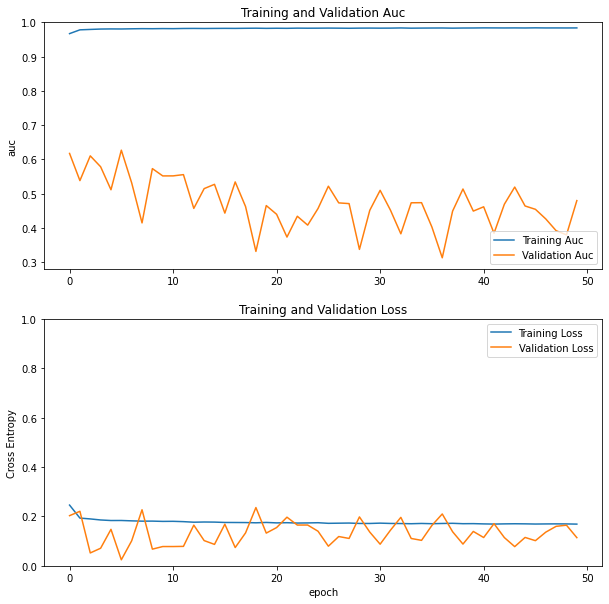

auc= 0.73


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56862
           1       0.05      0.90      0.10       100

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962



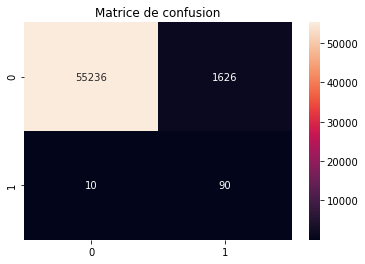

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_smote, y_train_smote , validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_smote, y_train_smote , validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

### 6.5.3. ADASYN

Une autre approche consiste à générer des échantillons synthétiques inversement proportionnels à la densité des exemples dans la classe minoritaire.

C'est-à-dire, générer des exemples plus synthétiques dans les régions de l'espace des caractéristiques où la densité des exemples minoritaires est faible, et moins ou aucun où la densité est élevée.

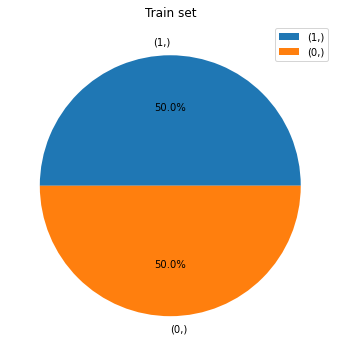

(array([0, 1], dtype=int64), array([20000, 20005], dtype=int64))

In [ ]:
adasyn_strategy = {0:20000, 1:20000 }
X_train_adasyn, y_train_adasyn =  ADASYN(sampling_strategy=adasyn_strategy, random_state=1997).fit_resample(X_train, y_train)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_adasyn).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_adasyn, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

56962/56962 [==============================] - 1s 22us/sample - loss: 0.2483 - auc: 0.3748
AUC: 37.48


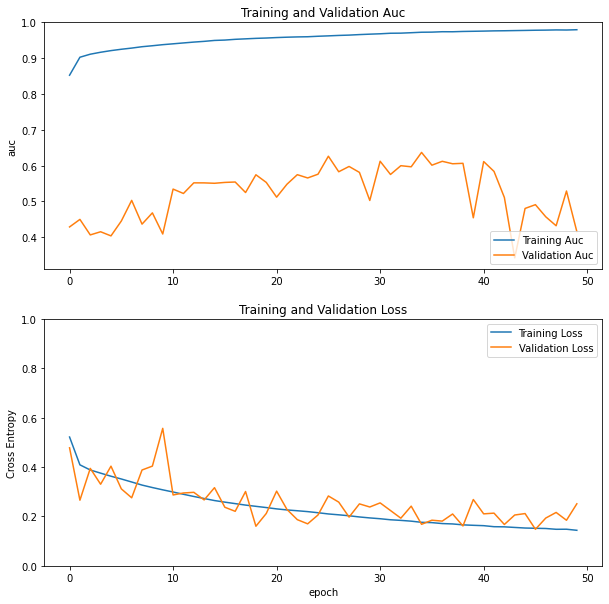

auc= 0.71


              precision    recall  f1-score   support

           0       1.00      0.89      0.94     56862
           1       0.01      0.93      0.03       100

    accuracy                           0.89     56962
   macro avg       0.51      0.91      0.48     56962
weighted avg       1.00      0.89      0.94     56962



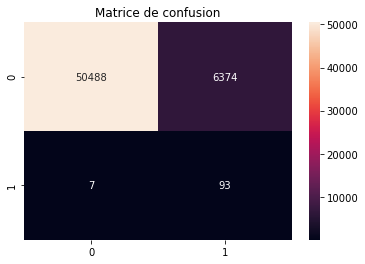


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

56962/56962 [==============================] - 1s 22us/sample - loss: 0.3396 - auc: 0.1435
AUC: 14.35


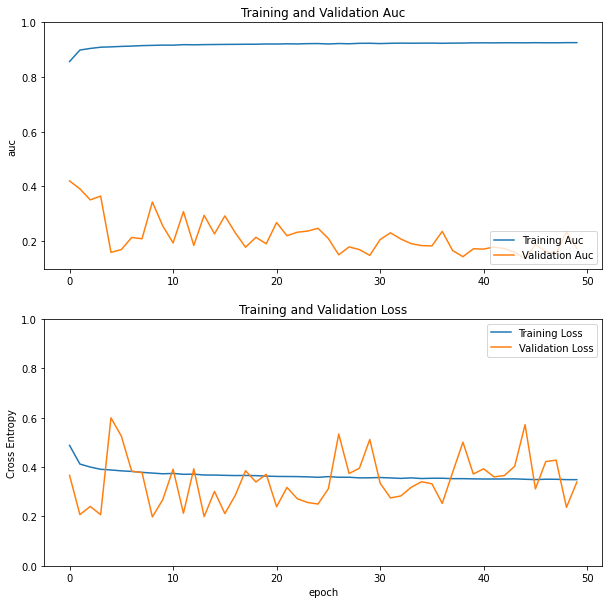

auc= 0.68


              precision    recall  f1-score   support

           0       1.00      0.89      0.94     56862
           1       0.01      0.95      0.03       100

    accuracy                           0.89     56962
   macro avg       0.51      0.92      0.48     56962
weighted avg       1.00      0.89      0.94     56962



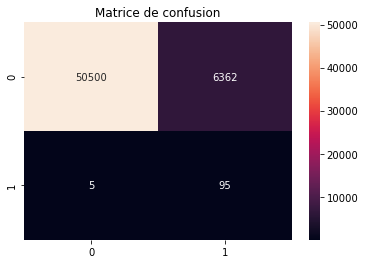

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_adasyn, y_train_adasyn, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_adasyn, y_train_adasyn, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

## 6.6. Entraînement avec undersampling


### 6.6.1. Random undersampling
cette technique consiste à retirez au hasard les échantillons de la classe majoritaire, avec ou sans remplacement.

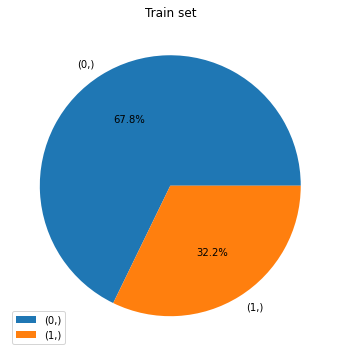

(array([0, 1]), array([600, 285], dtype=int64))

In [ ]:
under_strategy = {0:600, 1:285}
X_train_under, y_train_under =  sampling(X_train, y_train, sampling_strategy=under_strategy, random_state=1997)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_under).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_under, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

56962/56962 [==============================] - 1s 21us/sample - loss: 0.1113 - auc: 0.7302
AUC: 73.02


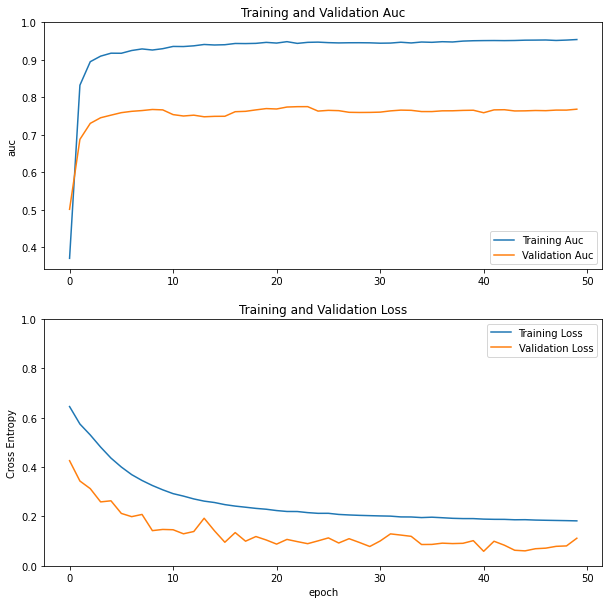

auc= 0.76


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56862
           1       0.16      0.88      0.28       100

    accuracy                           0.99     56962
   macro avg       0.58      0.94      0.64     56962
weighted avg       1.00      0.99      0.99     56962



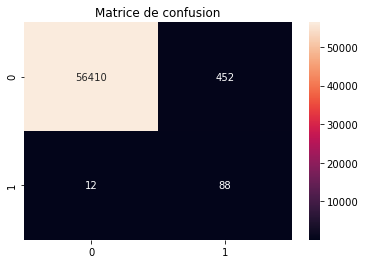


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

56962/56962 [==============================] - 1s 21us/sample - loss: 0.1082 - auc: 0.6935
AUC: 69.35


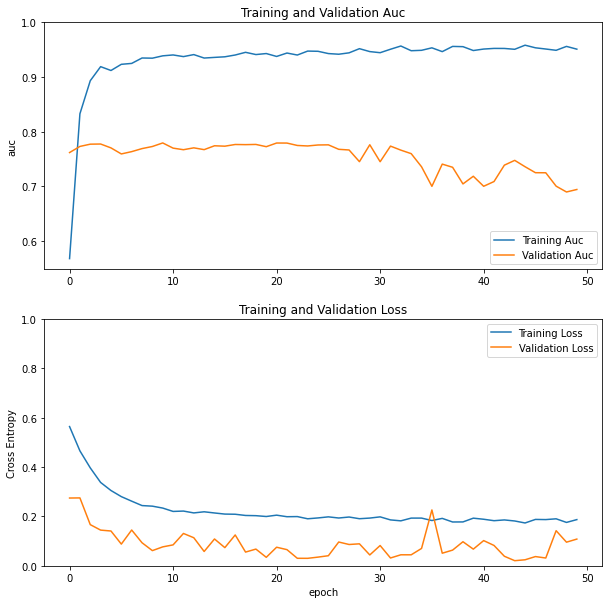

auc= 0.75


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56862
           1       0.08      0.88      0.14       100

    accuracy                           0.98     56962
   macro avg       0.54      0.93      0.57     56962
weighted avg       1.00      0.98      0.99     56962



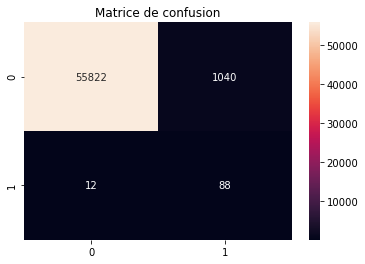

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_under, y_train_under, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_under, y_train_under, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

### 6.6.2. Tomek links

Cette technique onsiste à supprimer les observations de la classe majoritaire chevauchant celles de la classe minoritaire jusqu'à ce que toutes les paires de voisins les plus proches à une distance minimale soient de la même classe.

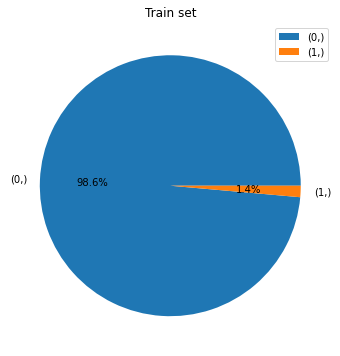

(array([0, 1], dtype=int64), array([19985,   285], dtype=int64))

In [ ]:
X_train_tomek, y_train_tomek = TomekLinks(n_jobs=-1).fit_resample(X_train, y_train)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_tomek).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_tomek, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

56962/56962 [==============================] - 1s 20us/sample - loss: 0.0054 - auc: 0.7572
AUC: 75.72


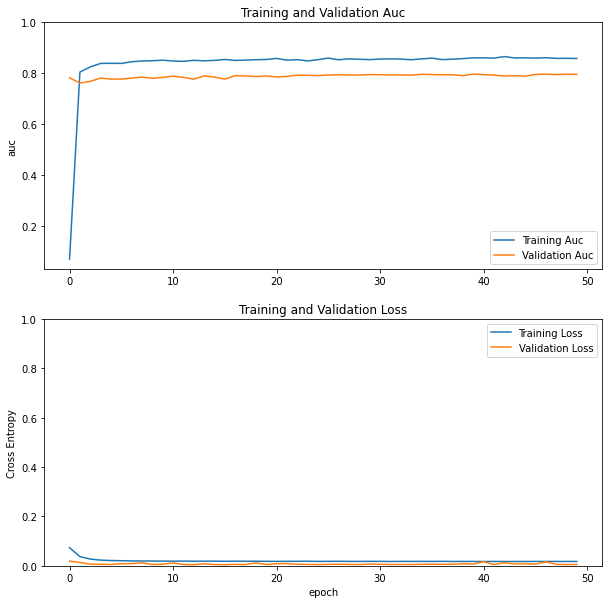

auc= 0.77


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.81      0.82      0.82       100

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962



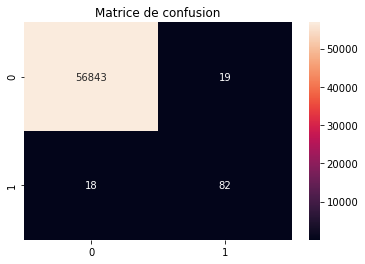


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

56962/56962 [==============================] - 1s 22us/sample - loss: 0.0133 - auc: 0.6874
AUC: 68.74


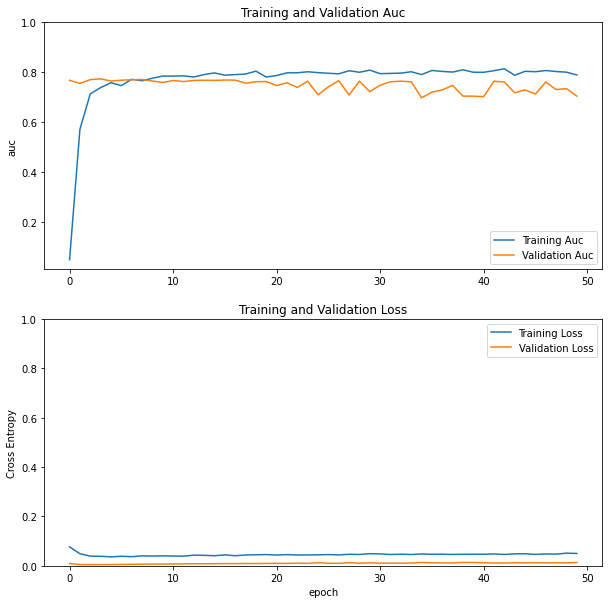

auc= 0.79


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.74      0.84      0.79       100

    accuracy                           1.00     56962
   macro avg       0.87      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962



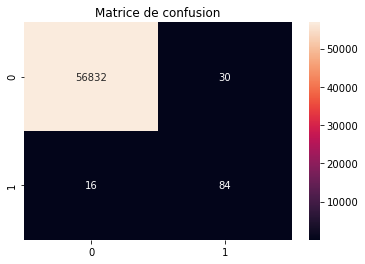

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_tomek, y_train_tomek, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_tomek, y_train_tomek, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

## 6.7. Entraînement avec une approche hybrid de resampling

### 6.7.1. Random oversampling + Tomek links

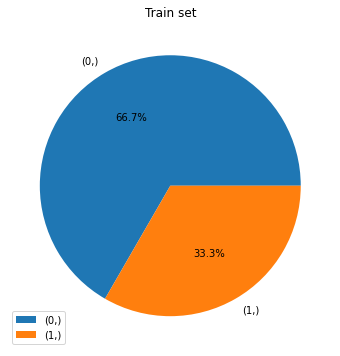

(array([0, 1]), array([20000, 10000], dtype=int64))

In [ ]:
over_strategy = {0:20000, 1:10000 }

X_train_over, y_train_over =  sampling(X_train, y_train, sampling_strategy=over_strategy, random_state=1997)

X_train_over_tomek, y_train_over_tomek = TomekLinks(n_jobs=-1).fit_resample(X_train_over, y_train_over)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_over_tomek).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_over_tomek, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

56962/56962 [==============================] - 1s 22us/sample - loss: 0.0560 - auc: 0.7609
AUC: 76.09


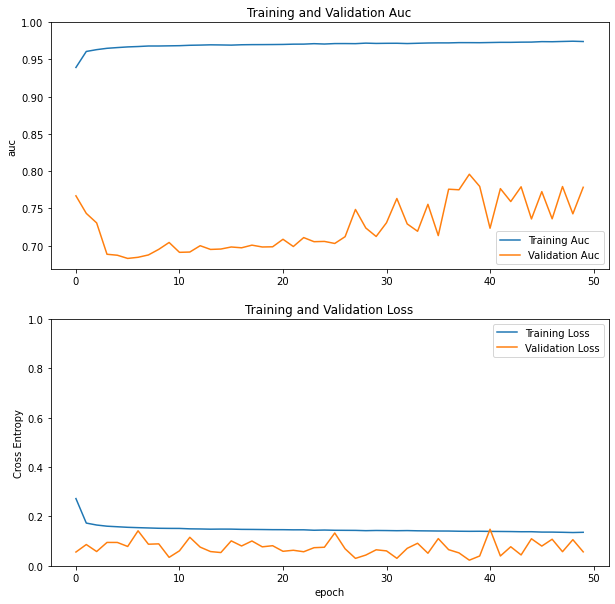

auc= 0.78


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56862
           1       0.14      0.89      0.25       100

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.62     56962
weighted avg       1.00      0.99      0.99     56962



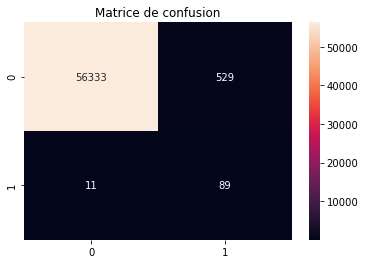


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

56962/56962 [==============================] - 1s 22us/sample - loss: 0.0843 - auc: 0.5984
AUC: 59.84


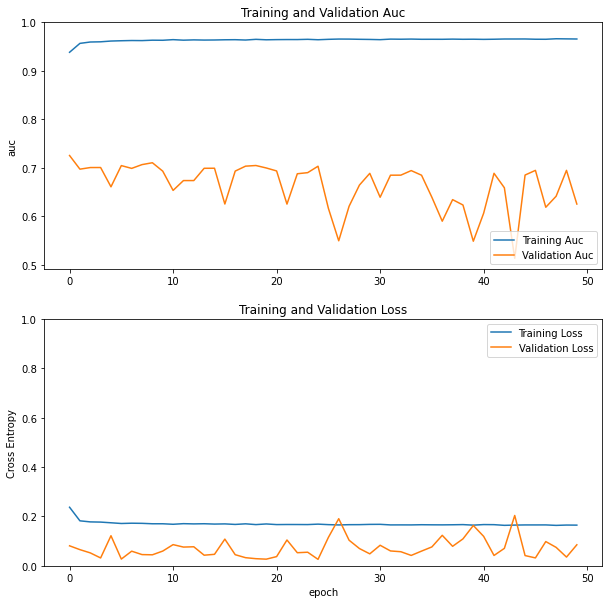

auc= 0.76


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56862
           1       0.08      0.90      0.15       100

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962



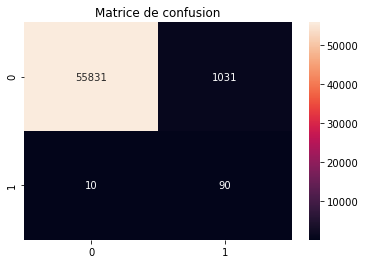

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_over_tomek, y_train_over_tomek , validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_over_tomek, y_train_over_tomek , validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

### 6.7.2. SMOTE + Tomek links

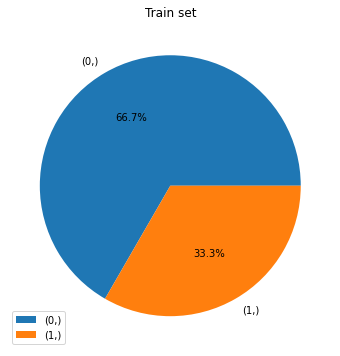

(array([0, 1], dtype=int64), array([20000, 10000], dtype=int64))

In [ ]:
smote_strategy = {0:20000, 1:10000 }
smote = SMOTE(sampling_strategy=smote_strategy, random_state=1997)

tomek = TomekLinks(n_jobs=-1)

steps = [('smote', smote), ("tomek", tomek)]
pipeline_over_tomek = Pipeline(steps=steps)


X_train_smote_tomek, y_train_smote_tomek = pipeline_over_tomek.fit_resample(X_train, y_train)

# Afficher les nouvelles proportion des classe  
pd.DataFrame(y_train_smote_tomek).value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6), label="", title="Train set")
plt.legend()
plt.show()

# Afficher le nombre d'observations dans chaque classe
np.unique(y_train_smote_tomek, return_counts=True)

baseline model fit

elaborate model fit

------------------------------EVALUATION DU MODEL DE BASE--------------------------------

56962/56962 [==============================] - 1s 22us/sample - loss: 0.0516 - auc: 0.7607
AUC: 76.07


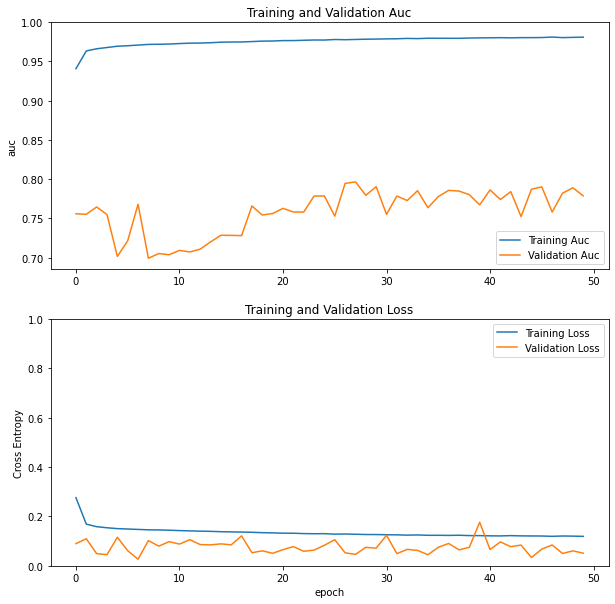

auc= 0.75


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56862
           1       0.12      0.86      0.21       100

    accuracy                           0.99     56962
   macro avg       0.56      0.92      0.60     56962
weighted avg       1.00      0.99      0.99     56962



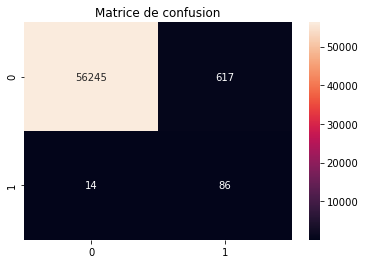


------------------------------EVALUATION DU MODEL ELABORE--------------------------------

56962/56962 [==============================] - 1s 24us/sample - loss: 0.0618 - auc: 0.5915
AUC: 59.15


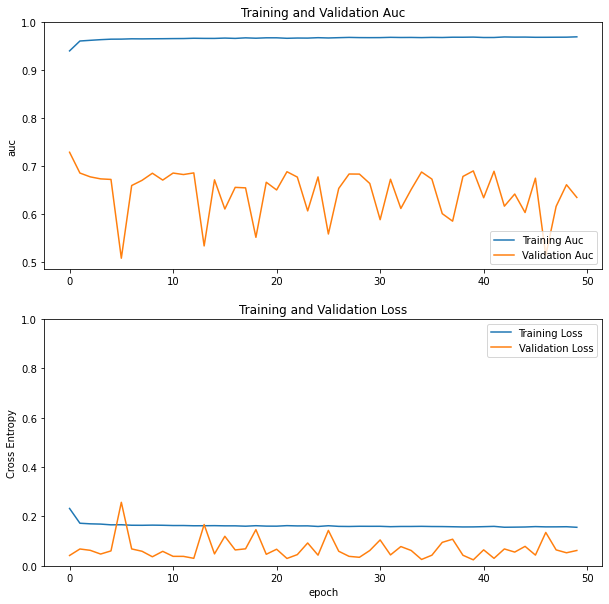

auc= 0.75


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56862
           1       0.11      0.88      0.20       100

    accuracy                           0.99     56962
   macro avg       0.56      0.93      0.60     56962
weighted avg       1.00      0.99      0.99     56962



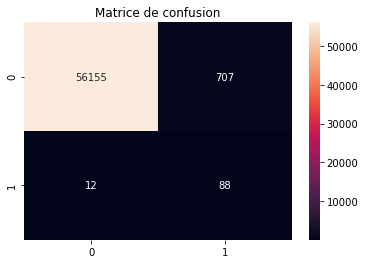

In [ ]:
# Construire le modèle de base et le modèle élaboré
baseline_model = create_baseline_model()
elaborate_model = create_elaborate_model()

# Entrainer les deux modèles sur l'ensemble d'entraînement
print("baseline model fit")
history_b= baseline_model.fit(X_train_smote_tomek, y_train_smote_tomek , validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)
print("\nelaborate model fit")
history_e= elaborate_model.fit(X_train_smote_tomek, y_train_smote_tomek , validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=0)

print("\n------------------------------EVALUATION DU MODEL DE BASE--------------------------------\n")
# Evaluer le model de base
_, auc_score = baseline_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de base
plot_training_history(history_b.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = baseline_model.predict(X_test)
evaluation(pred_prob, y_test)

print("\n------------------------------EVALUATION DU MODEL ELABORE--------------------------------\n")
# Evaluer le model élaboré
_, auc_score = elaborate_model.evaluate(X_test, y_test)
print('AUC: %.2f' % (auc_score*100))

# Afficher la courbe d'apprentissage du model de élaboré
plot_training_history(history_e.history)

# Evaluation avec la métrique "auc" de sklearn, et affichage de la matrice de confusion
pred_prob = elaborate_model.predict(X_test)
evaluation(pred_prob, y_test)

## 7. Conclusion

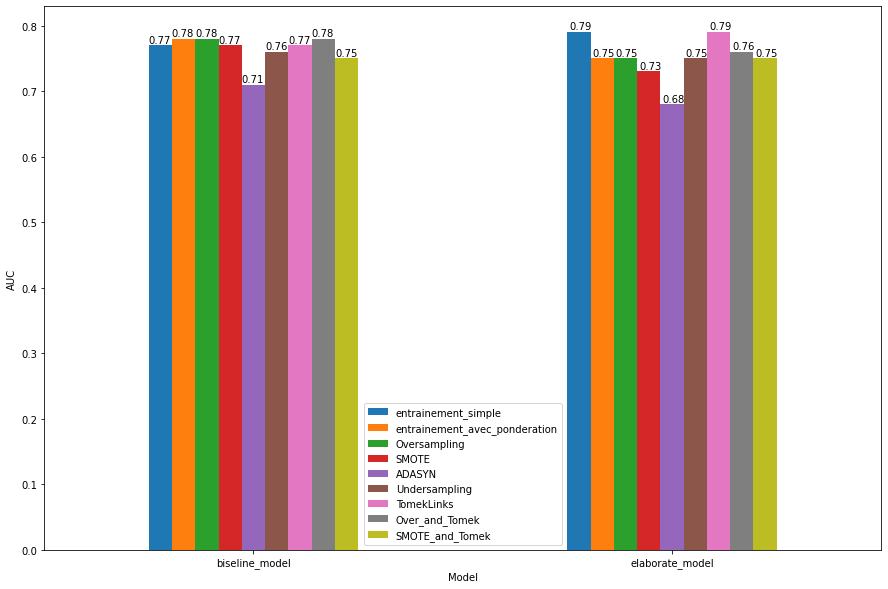

In [ ]:
# Définir les résultats de chaque méthodes
resultat = {
    "entrainement_simple": [0.77, 0.79],
    "entrainement_avec_ponderation":[0.78, 0.75],
    "Oversampling": [0.78, 0.75],
    "SMOTE": [0.77, 0.73],
    "ADASYN": [0.71, 0.68],
    "Undersampling": [0.76, 0.75],
    "TomekLinks": [0.77, 0.79],
    "Over_and_Tomek": [0.78, 0.76],
    "SMOTE_and_Tomek": [0.75, 0.75] 
            }

resultat = pd.DataFrame(resultat, index=["biseline_model", "elaborate_model"])

# Afficher les résultats
ax = resultat.plot(kind='bar', figsize=(15, 10), rot=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.set_xlabel("Model")
ax.set_ylabel("AUC")
plt.show()

le meilleur résultat est 79% (AUC), trouvé en utilisant l'approche simple (sans l'utilisation de poids), et la méthode de sous-échantillonnage.